In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import learning_curve



In [2]:
# Load dataset
train_df = pd.read_csv('/kaggle/input/heartbeat/mitbih_train.csv', header=None)

# Separate Features (X) and Labels (y)
X_train = train_df.iloc[:, :-1]  # All columns except the last one (ECG signal data)
y_train = train_df.iloc[:, -1]   # Last column (heartbeat class)

print("Train features Shape:", X_train.shape)  # Should be (Number of samples, Number of features)
print("Train labels Shape:", y_train.shape)    # Should be (Number of samples,)
print("Unique Labels:", y_train.unique())  # Should output: [0, 1, 2, 3, 4]

# Check for missing values and duplicates
print(f"Missing values in train feature data: {X_train.isnull().sum().sum()}")
print(f"Missing values in train label data: {y_train.isnull().sum().sum()}")
print(f"Duplicates in train feature data: {X_train.duplicated().sum()}")



Train features Shape: (87554, 187)
Train labels Shape: (87554,)
Unique Labels: [0. 1. 2. 3. 4.]
Missing values in train feature data: 0
Missing values in train label data: 0
Duplicates in train feature data: 0


In [3]:
test_df = pd.read_csv("/kaggle/input/heartbeat/mitbih_test.csv", header=None)
X_test = test_df.iloc[:,:-1]
y_test = test_df.iloc[:,-1]

print("Test features Shape:", X_test.shape)  # Should be (Number of samples, Number of features)
print("Test labels Shape:", y_test.shape)    # Should be (Number of samples,)
print("Unique Labels:", y_test.unique())  # Should output: [0, 1, 2, 3, 4]

# Check for missing values and duplicates
print(f"Missing values in test feature data: {X_test.isnull().sum().sum()}")    
print(f"Missing values in test label data: {y_test.isnull().sum().sum()}")
print(f"Duplicates in test feature data: {X_test.duplicated().sum()}")


Test features Shape: (21892, 187)
Test labels Shape: (21892,)
Unique Labels: [0. 1. 2. 3. 4.]
Missing values in test feature data: 0
Missing values in test label data: 0
Duplicates in test feature data: 0


In [4]:
labels = {
    0: "N",
    1: "S",
    2: "V",
    3: "F",
    4: "Q"
}


<ipython-input-5-700f5f4754c9>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(f'{train_counts[i]}',


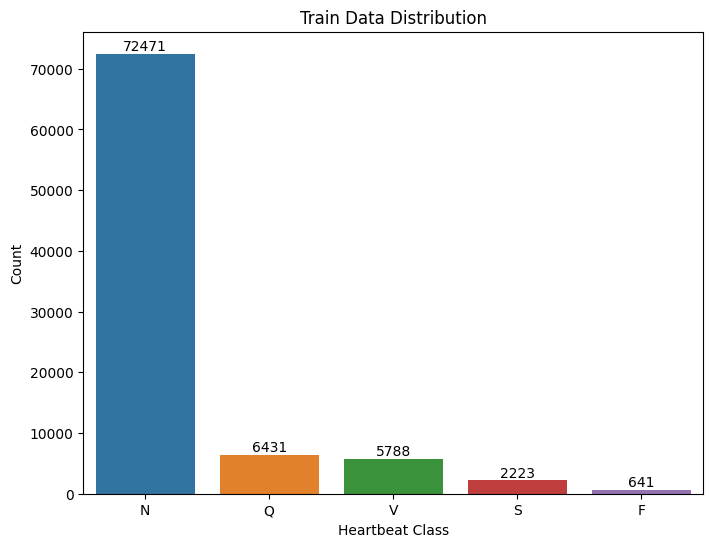

In [5]:
train_counts = train_df.iloc[:,-1].value_counts().rename(labels)

plt.figure(figsize=(8,6))
ax = sns.barplot(x=train_counts.index, y= train_counts.values)

for i,p in enumerate(ax.patches):
    ax.annotate(f'{train_counts[i]}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.title("Train Data Distribution")
plt.xlabel("Heartbeat Class")
plt.ylabel("Count")
plt.show()


<ipython-input-6-11f5455881b9>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(f'{test_counts[i]}',


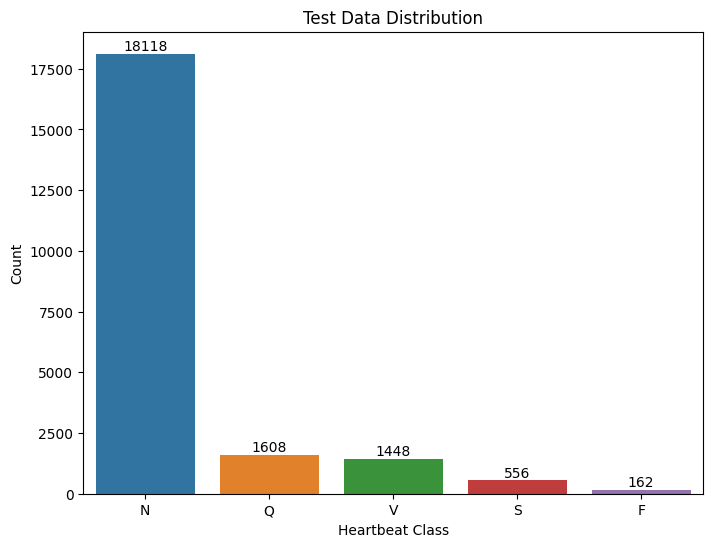

In [6]:
test_counts = test_df.iloc[:,-1].value_counts().rename(labels)

plt.figure(figsize=(8,6))
ax = sns.barplot(x=test_counts.index, y= test_counts.values)

for i,p in enumerate(ax.patches):
    ax.annotate(f'{test_counts[i]}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)
    
plt.title("Test Data Distribution") 
plt.xlabel("Heartbeat Class")
plt.ylabel("Count")
plt.show()



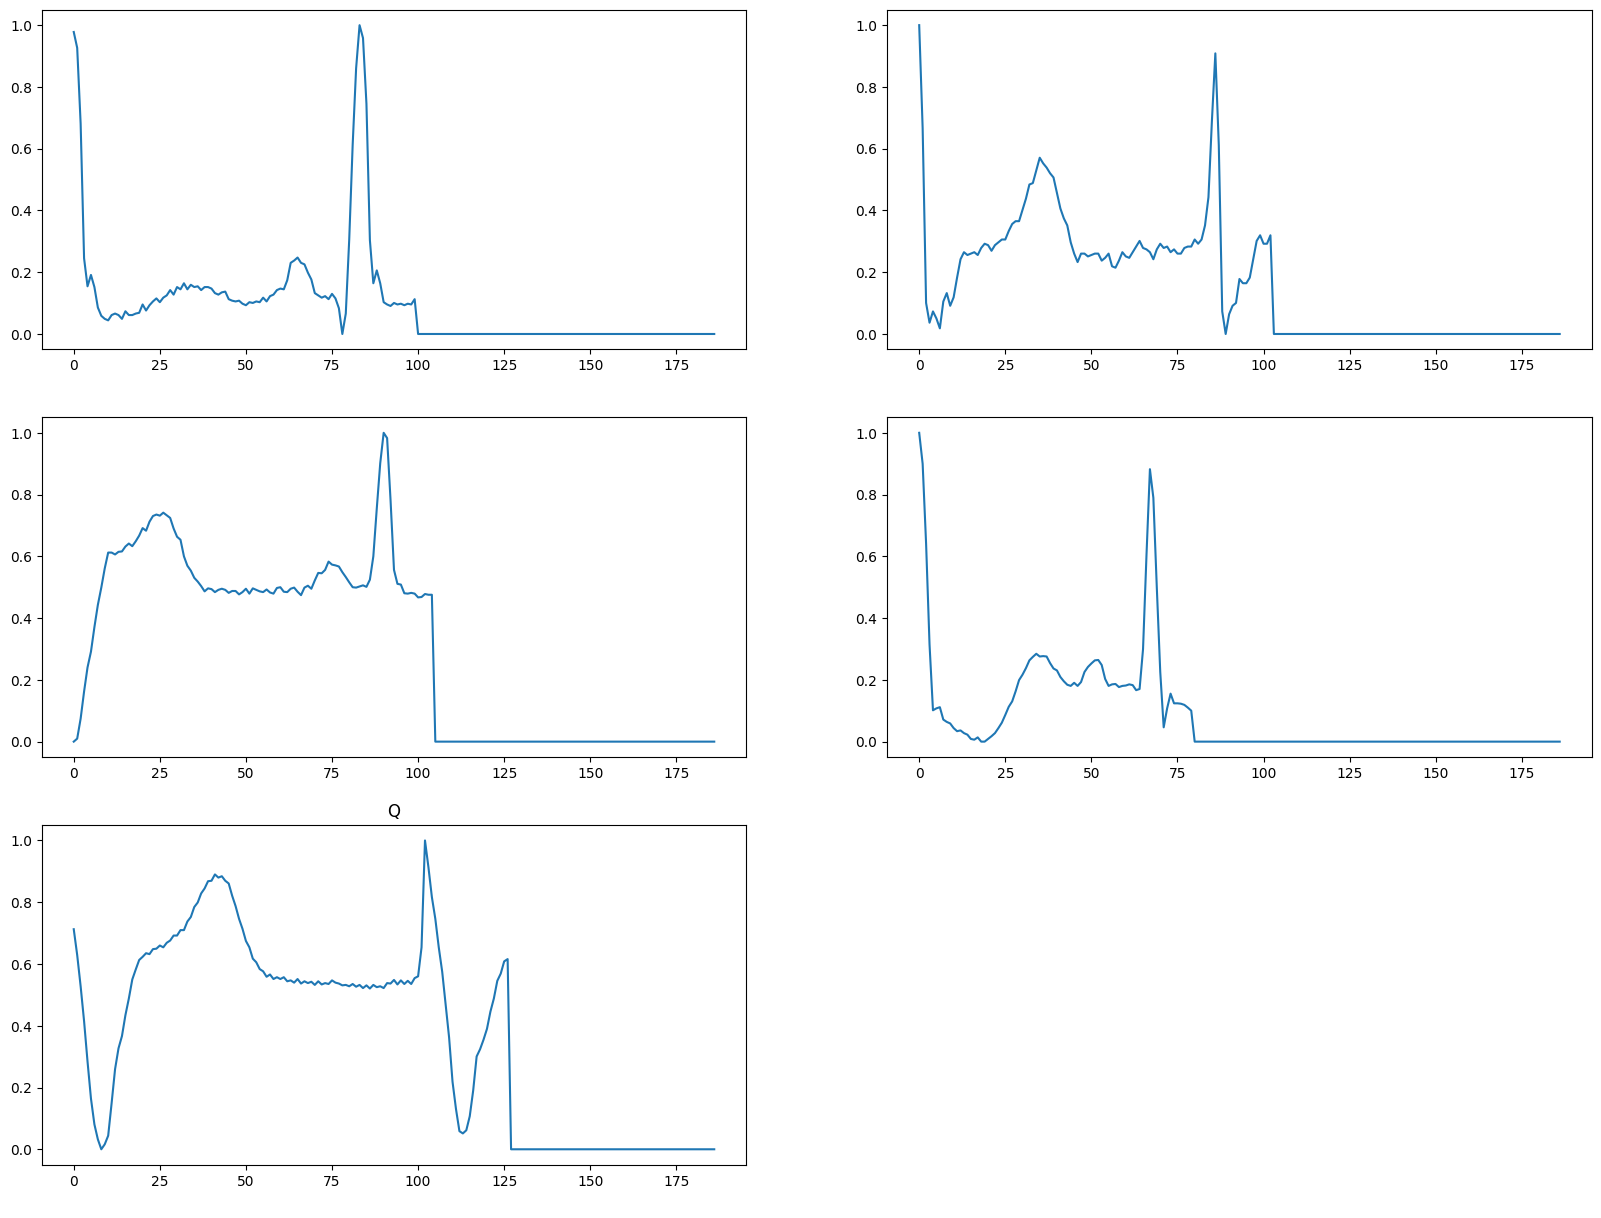

In [7]:
train_classes = train_df.iloc[:,-1].unique()

plt.figure(figsize=(20,15))

for i, c in enumerate(train_classes):
    plt.subplot(3,2,i+1)
    plt.plot(train_df[train_df.iloc[:, -1]==c].iloc[0,:-1])

plt.title(f'{list(labels.values())[i]}')
plt.xlabel(" ")

plt.show()


In [8]:
# Scailing the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Define the number of samples for the validation set based on the test data size
n_test_samples = X_test_scaled.shape[0]

# Split the training data into new training and validation sets
X_val, X_test_new, y_val, y_test_new = train_test_split(X_test_scaled, y_test, test_size=0.5, random_state=42, stratify=y_test)
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test_new = np.reshape(X_test_new, (X_test_new.shape[0], X_test_new.shape[1], 1))

print(f"New Training set size: {X_train_scaled.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test_new.shape[0]}")


New Training set size: 87554
Validation set size: 10946
Test set size: 10946


## LSTM


In [9]:
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(128,input_shape=(X_train.shape[1],1),return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dense(5,activation='softmax'))
    return model


In [10]:
lstm_model = build_lstm_model()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
lstm_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])


In [12]:
lstm_history = lstm_model.fit(X_train_scaled, y_train, 
                              epochs=20, batch_size=32,
                              validation_data=(X_val, y_val),
                              callbacks= [tf.keras.callbacks.EarlyStopping(patience=5)])


Epoch 1/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 58s 20ms/step - accuracy: 0.8286 - loss: 0.6653 - val_accuracy: 0.8283 - val_loss: 0.5486
Epoch 2/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 54s 20ms/step - accuracy: 0.8343 - loss: 0.5302 - val_accuracy: 0.8276 - val_loss: 0.6563
Epoch 3/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 55s 20ms/step - accuracy: 0.8465 - loss: 0.5541 - val_accuracy: 0.8902 - val_loss: 0.4024
Epoch 4/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 55s 20ms/step - accuracy: 0.8863 - loss: 0.4167 - val_accuracy: 0.8682 - val_loss: 0.5258
Epoch 5/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 55s 20ms/step - accuracy: 0.8562 - loss: 0.5630 - val_accuracy: 0.8276 - val_loss: 0.6586
Epoch 6/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 57s 21ms/step - accuracy: 0.8342 - loss: 0.6358 - val_accuracy: 0.8875 - val_loss: 0.4334
Epoch 7/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 56s 21ms/step - accuracy: 0.8927 - loss: 0.3977 - val_accuracy: 0.9224 - val_loss: 0.3266
Epoch 8/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 57s 21ms/step - accuracy: 0.9138 -

In [13]:
y_test_pred_lstm = lstm_model.predict(X_test_new).argmax(axis=1)


343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


In [14]:
# Evaluate LSTM Model on Test Data
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(X_test_new, y_test_new, verbose=0)
print(f"LSTM Test Loss: {lstm_test_loss:.4f}")
print(f"LSTM Test Accuracy: {lstm_test_acc:.4f}")


LSTM Test Loss: 0.2155
LSTM Test Accuracy: 0.9441


In [15]:
# LSTM classification report
print("LSTM Classification Report:")
print(classification_report(y_test_new, y_test_pred_lstm))


LSTM Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      9059
         1.0       0.87      0.12      0.21       278
         2.0       0.84      0.83      0.84       724
         3.0       0.00      0.00      0.00        81
         4.0       0.98      0.89      0.93       804

    accuracy                           0.94     10946
   macro avg       0.73      0.57      0.59     10946
weighted avg       0.94      0.94      0.93     10946



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
